# Automatic Differentiation

* Modified from this PR by @dhairyagandhi96: https://github.com/FluxML/model-zoo/pull/77


In [3]:
;tree -L 3 ..

..
├── 12-29-work
│   ├── 1-automatic-differentiation.ipynb
│   ├── 2.linear-regression-simple-y=mx+b.ipynb
│   ├── 3.logistic-regression-iris_WIP.ipynb
│   ├── 4.chinese-characters-etl.WORKING.ipynb
│   ├── 5.chinese-characters-cnn.ipynb
│   ├── LICENSE.md
│   ├── README.md
│   ├── Untitled.ipynb
│   ├── chinese-characters-cnn.jl
│   ├── fibonacci.ipynb
│   ├── plot_gradient_works.ipynb
│   └── understanding-back-function.ipynb
├── archived
│   ├── accuracies.jld
│   ├── chinese-char-logistic.ipynb
│   ├── chinese-characters-cnn.jl
│   ├── flux-basics-example.ipynb
│   ├── intro.ipynb
│   ├── iris.jl
│   ├── linear-regression-iris.ipynb
│   ├── mnist-con-orig-tutorial.ipynb
│   ├── mnist-mlp-tutorial-works.ipynb
│   ├── my-cifar10.ipynb
│   ├── normalizing-image-data.html
│   └── normalizing-image-data.ipynb
└── input
    ├── ch_train_set
    │   ├── a440
    │   ├── a447
    │   ├── a448
    │   ├── a44a
    │   ├── a451
    │   ├── a453
    │   ├── a454
    │   ├── a455
    │   ├── 

In [3]:
using Plots

using Flux.Tracker: gradient

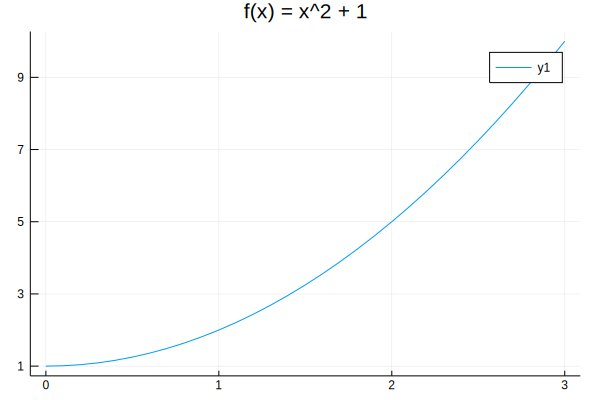

In [32]:
# Automatic Differentiation
# -------------------------

# You probably learned to take derivatives in school. We start with a simple
# mathematical function like:

f(x) = x^2 + 1

xs = collect(0:.1:3)

plot(xs, f.(xs), title="f(x) = x^2 + 1", yticks=1:2:9)

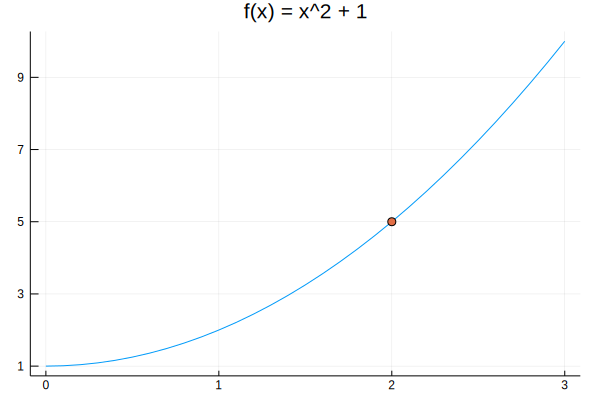

In [33]:
# pick a point on the line:

x1 = 2
y1 = f(x1)

plot(xs, f.(xs), title="f(x) = x^2 + 1", yticks=1:2:9)
scatter!((x1, y1), leg=false)

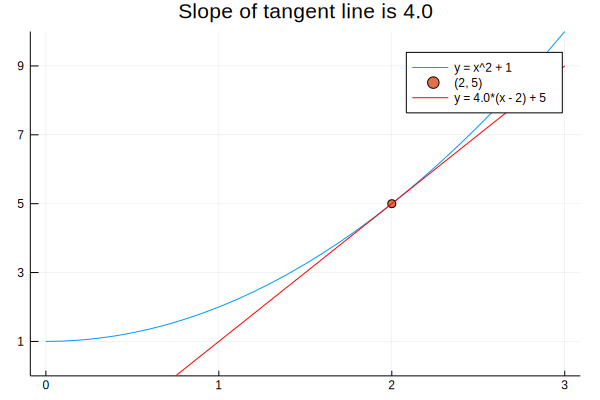

In [34]:
# Now, we can use Flux to get the derivative (slope) at that point.
using Flux.Tracker: gradient, data

# "The gradient function takes another Julia function f and a set of arguments, 
# and returns the gradient with respect to each argument." 
# - https://fluxml.ai/Flux.jl/stable/models/basics/

# The 'data' function extracts just the numeric value from the object.


m = data(gradient(f, 2)[1])

# using point-slope formula.
# y - y1 = m*(x - x1)
g(x) = m*(x - x1) + y1



plot(xs, f.(xs), label="y = x^2 + 1")
scatter!((x1, y1), label="($x1, $y1)")
plot!(xs, g.(xs), color=:red, ylim=(0, 10), label="y = $m*(x - $x1) + $y1", title="Slope of tangent line is $m", yticks=1:2:9)

In [ ]:
# Flux can work out 

In [75]:
# Flux's AD can handle any Julia code you throw at it, including loops,
# recursion and custom layers, so long as the mathematical functions you call
# are differentiable.

# Therefore, we can find the derivatives of more complicated functions, e.g. 
# functions that are the composition of functions, e.g. the chain rule.

f(x) = sin(x)
g(x) = 2x

#       sin(2x)
h(x) = (f ∘ g)(x)

gradient(h, π/4)

(1.2246467991473532e-16 (tracked),)

In [80]:


softmax([3])

#relu(5)

#relu([1 2]*[3, 4])

MethodError: MethodError: no method matching softmax!(::Array{Int64,1}, ::Array{Int64,1})
Closest candidates are:
  softmax!(::Any) at /home/jw/.julia/packages/NNlib/0EAe7/src/softmax.jl:28

In [76]:
# which is basically what is used for deep learning.
# suppose the training set has 2 features.
f(x) = [1 2]*x

# use activation function of relu
g(x) = relu(x)

node(x) = (g ∘ f)(x)

[3, 4]

gradient(node, [3, 4])

ErrorException: Function output is not scalar

In [30]:
# In simple cases it's pretty easy to work out the gradient by hand – here it's
# `2x`. But it's much easier to make Flux do the work for us!

using Flux.Tracker: derivative, gradient

df(x) = derivative(f, x)

df(5)

10.0 (tracked)

In [35]:
# Flux's AD can handle any Julia code you throw at it, including loops,
# recursion and custom layers, so long as the mathematical functions you call
# are differentiable. For example, we can differentiate a Taylor approximation
# to the `sin` function.

mysin(x) = sum((-1)^k*x^(1+2k)/factorial(1+2k) for k in 0:5)

x = 0.5

mysin(x), gradient(mysin, x)

(0.4794255386041834, (0.8775825618898637 (tracked),))

In [36]:
# You can see that the derivative we calculated is very close to `cos(x)`, as we
# expect.

sin(x), cos(x)

(0.479425538604203, 0.8775825618903728)

In [65]:
# This gets more interesting when we consider functions that take *arrays* as
# inputs, rather than just a single number. For example, here's a function that
# takes a matrix and two vectors (the definition itself is arbitrary)

myloss(W, b, x) = sum(W * x .+ b)

W = randn(3, 5)
b = zeros(3)
x = rand(5)

gs = gradient(myloss, W, b, x)

# Shows gradients with respect to third argument to function, the vector x.
# can see the others with gs[1], gs[2]
gs[3]

Tracked 5-element Array{Float64,1}:
  1.5547043260805609
  1.2631749557750251
 -0.2084961704208283
  1.5474905706036184
  0.3010981261311019

In [52]:
# Now we get gradients for each of the inputs `W`, `b` and `x`, which will come
# in handy when we want to train models.

In [66]:
# Because ML models can contain hundreds of parameters, Flux provides a slightly
# different way of writing `gradient`. We instead mark arrays with `param` to
# indicate that we want their derivatives. `W` and `b` represent the weight and
# bias respectively.

using Flux.Tracker: param, back!, grad

W = param(randn(3, 5))
b = param(zeros(3))
x = rand(5)

y = sum(W * x .+ b)

-3.8709841472228987 (tracked)

In [67]:
# Anything marked `param` becomes *tracked*, indicating that Flux keeping an eye
# on its gradient. We can now call

back!(y) # Run backpropagation

grad(W), grad(b)

([0.284253 0.672952 … 0.559764 0.669411; 0.284253 0.672952 … 0.559764 0.669411; 0.284253 0.672952 … 0.559764 0.669411], [1.0, 1.0, 1.0])

In [68]:
# We can now grab the gradients of `W` and `b` directly from those parameters.

In [70]:
# This comes in handy when working with *layers*. A layer is just a handy
# container for some parameters. For example, `Dense` does a linear transform
# for you.

using Flux

model = Dense(10, 5)

x = rand(10)

model(x)

Tracked 5-element Array{Float64,1}:
 -0.11617803003622641
 -0.37914265307498257
  0.6478625085961149 
  0.9636690391884307 
  0.2452617010221381 

In [71]:
# We can easily get the parameters of any layer or model with params with
# `params`.

params(m)

2-element Array{Any,1}:
 Flux.Tracker.TrackedReal{Float64}[-0.562382 (tracked) 0.237166 (tracked) … 0.486642 (tracked) -0.0265328 (tracked); -0.330083 (tracked) 0.185609 (tracked) … 0.569349 (tracked) -0.102732 (tracked); … ; -0.391223 (tracked) -0.539947 (tracked) … 0.0783253 (tracked) 0.387575 (tracked); -0.509724 (tracked) 0.0682836 (tracked) … -0.289083 (tracked) 0.0743014 (tracked)]
 Flux.Tracker.TrackedReal{Float64}[0.0 (tracked), 0.0 (tracked), 0.0 (tracked), 0.0 (tracked), 0.0 (tracked)]                                                                                                                                                                                                                                                                 

In [ ]:
# This makes it very easy to do backpropagation and get the gradient for all
# parameters in a network, even if it has many parameters.

m = Chain(Dense(10, 5, relu), Dense(5, 2), softmax)

l = sum(Flux.crossentropy(m(x), [0.5, 0.5]))
back!(l)

grad.(params(m))

In [ ]:
# You don't have to use layers, but they can be convient for many simple kinds
# of models and fast iteration.

In [ ]:
# The next step is to update our weights and perform optimisation. As you might be
# familiar, *Gradient Descent* is a simple algorithm that takes the weights and steps
# using a learning rate and the gradients. `weights = weights - learning_rate * gradient`.

using Flux.Tracker: update!

η = 0.1
for p in params(m)
  update!(p, -η * grad(p))
end


In [ ]:
# While this is a valid way of updating our weights, it can get more complicated as the
# algorithms we use get more involved. 


In [ ]:
# Flux comes with a bunch of pre-defined optimisers and makes writing our own really simple.
# We just give it the model parameters and any other parameters of the optimisers themselves.

opt = SGD(params(m), 0.01)
opt() # updates the weights


In [ ]:
# `Training` a network reduces down to iterating on a dataset mulitple times, performing these
# steps in order. Just for a quick implementation, let’s train a network that learns to predict
# `0.5` for every input of 10 floats. `Flux` defines the `train!` function to do it for us.

data, labels = rand(10, 100), fill(0.5, 2, 100)

loss(x, y) = sum(Flux.crossentropy(m(x), y))

Flux.train!(loss, [(data,labels)], opt)

You don't have to use `train!`. In cases where aribtrary logic might be better suited,
you could open up this training loop like so:

```julia
  for d in training_set # assuming d looks like (data, labels)
    # our super logic
    l = loss(d...)
    Tracker.back!(l)
    opt()
  end
```
